In [5]:
from astropy.io import fits
import pandas as pd
from astropy.table import Table
import numpy as np
import sys
import pickle
import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import bcg_parameter_file as p
import data_ingestion as dload
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle

In [6]:
irac_images_path = p.data_path + "IRAC_images/"
mips_images_path = p.data_path + "MIPS_images/"
alma_images_path = p.data_path + "ALMA_images/"
irac_objects_path = p.data_path + "irac_prior_positions.pkl"
mips_objects_path = p.data_path + "mips_prior_positions.pkl"

def return_filename(path:str):
    return glob.glob(path)[0]

with open(irac_objects_path, "rb") as f:
    irac_objects = pickle.load(f)
with open(mips_objects_path, "rb") as f:
    mips_objects = pickle.load(f)

bcgs = list(dload.bcg_regions_load()['id'])

In [9]:
def plot_postage_stamps(bcg:str):

    irac_image = return_filename(irac_images_path + bcg + "*.fits")
    mips_image = return_filename(mips_images_path + bcg + "*.fits")
    alma_image = return_filename(alma_images_path + bcg + "*.fits")

    data_irac,header_irac, wcs_irac = dload.read_any_fits(irac_image)
    data_mips,header_mips, wcs_mips = dload.read_any_fits(mips_image)
    data_alma,header_alma, wcs_alma = dload.read_alma_fits(alma_image)

    fig = plt.figure(dpi = 300)

    ax1 = fig.add_subplot(131, projection=wcs_alma)
    ax2 = fig.add_subplot(132, projection=wcs_alma,sharey=ax1)
    ax3 = fig.add_subplot(133, projection=wcs_alma,sharey=ax1)

    irac_trans = ax1.get_transform(wcs_irac)
    mips_trans = ax2.get_transform(wcs_mips)

    bmaj = header_alma['BMAJ']*u.deg.to(u.arcsec)/0.045
    bmin = header_alma['BMIN']*u.deg.to(u.arcsec)/0.045
    fwhm_maj = header_alma['BMAJ']*u.deg
    fwhm_min = header_alma['BMIN']*u.deg
    pa = header_alma['BPA'] + 90
    ra = header_alma['CRVAL1']
    dec = header_alma['CRVAL2']
    center = SkyCoord(ra*u.deg, dec*u.deg, frame = 'fk5')
    extent = SkyCoord(ra*u.deg - fwhm_maj, dec*u.deg + fwhm_min, frame='fk5')
    centerpix = wcs_alma.world_to_pixel(center)
    extpix = wcs_alma.world_to_pixel(extent)

    xlim = (centerpix[0]-250,centerpix[0]+250)
    ylim = (centerpix[1]-250,centerpix[1]+250)

    arad, brad = (extpix[0] - centerpix[0]), (extpix[1] - centerpix[1])
    beam1 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=bmaj, height=bmin, angle=pa, facecolor='yellow', edgecolor='white', zorder=11, lw = 0.2)
    beam2 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=bmaj, height=bmin, angle=pa, facecolor='yellow', edgecolor='white', zorder=11, lw = 0.2)
    beam3 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=bmaj, height=bmin, angle=pa, facecolor='yellow', edgecolor='white', zorder=11, lw = 0.2)


    im1 = ax1.imshow(data_irac, transform = irac_trans, origin = 'lower', interpolation='None',cmap = 'viridis',vmin = 0, vmax = 3)
    irac_coords_ra = np.array(irac_objects[bcg]['ra'])
    irac_coords_dec = np.array(irac_objects[bcg]['dec'])

    for ra, dec in zip(irac_coords_ra, irac_coords_dec):
        irac_coords = SkyCoord(ra * u.deg, dec * u.deg, frame = 'fk5')
        irac_coords_pix = wcs_irac.world_to_pixel(irac_coords)
        ax1.scatter(irac_coords_pix[0], irac_coords_pix[1], marker = '+', color = 'blue', zorder = 5, transform = irac_trans, s = 10, lw= 0.8, label = 'irac sources')

    im2 = ax2.imshow(data_mips, transform = mips_trans, origin = 'lower', interpolation='None',cmap = 'viridis',vmin = 0, vmax = 0.3)
    mips_coords_ra = np.array(mips_objects[bcg]['ra'])
    mips_coords_dec = np.array(mips_objects[bcg]['dec'])

    for ra, dec in zip(mips_coords_ra, mips_coords_dec):
        mips_coords = SkyCoord(ra * u.deg, dec * u.deg, frame = "fk5")
        mips_coords_pix = wcs_mips.world_to_pixel(mips_coords)
        ax2.scatter(mips_coords_pix[0], mips_coords_pix[1], marker = '+', color = 'blue', zorder = 5, transform = mips_trans, s = 10, lw= 0.8, label = 'mips sources')

    im3 = ax3.imshow(data_alma, origin = 'lower', interpolation='None',cmap = 'viridis',vmin = 0, vmax = 0.0001)

    ax1.add_patch(beam1)
    ax2.add_patch(beam2)
    ax3.add_patch(beam3)

    ax1.set_ylabel("Dec")
    ax1.set_xlabel("RA")
    ax2.set_xlabel("RA")
    ax3.set_xlabel("RA")

    ax1.coords[1].set_ticks_visible(False)
    ax1.coords[1].set_ticklabel_visible(False)
    ax2.coords[1].set_ticks_visible(False)
    ax2.coords[1].set_ticklabel_visible(False)
    ax3.coords[1].set_ticks_visible(False)
    ax3.coords[1].set_ticklabel_visible(False)
    ax1.coords[0].set_ticks_visible(False)
    ax1.coords[0].set_ticklabel_visible(False)
    ax2.coords[0].set_ticks_visible(False)
    ax2.coords[0].set_ticklabel_visible(False)
    ax3.coords[0].set_ticks_visible(False)
    ax3.coords[0].set_ticklabel_visible(False)

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)

    ax1.set_title("IRAC 3.6 $\mu$m", size = 10)
    ax2.set_title("MIPS 24 $\mu$m", size = 10)
    ax3.set_title("ALMA 1.2 mm", size = 10)

    return fig

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/vp/yhfll2qd0fgc3wnbgyc1yhyr0000gp/T/ipykernel_32448/2933960351.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(dpi = 300)


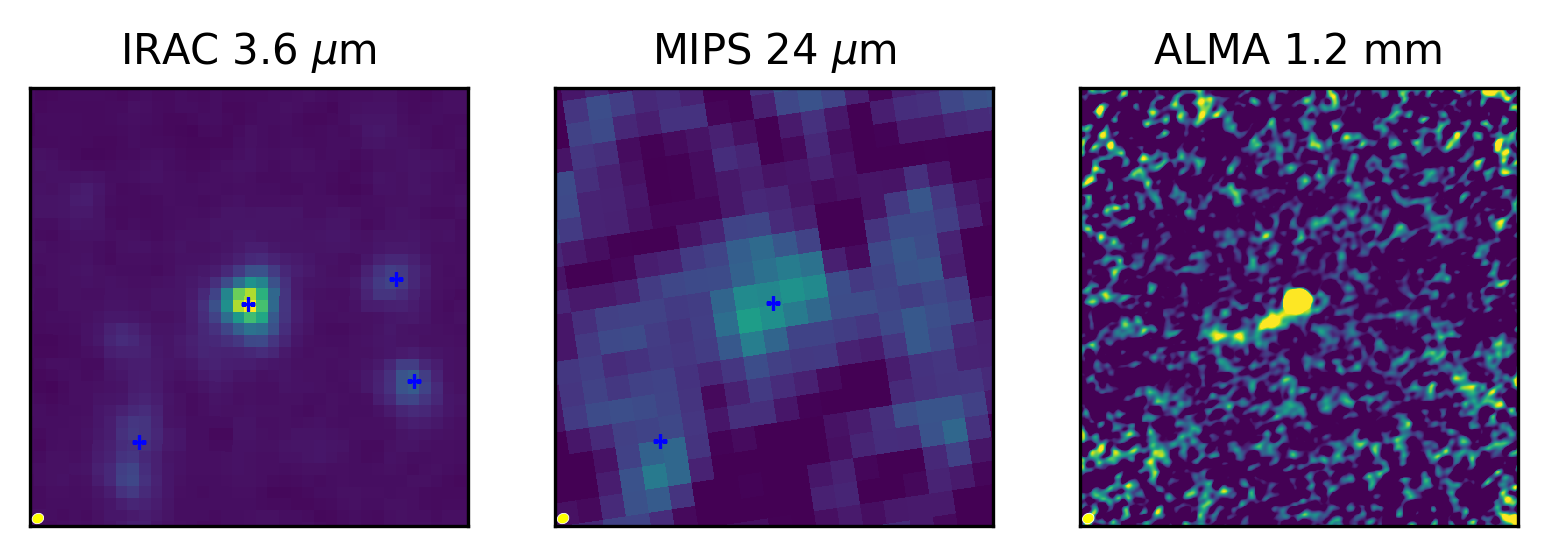

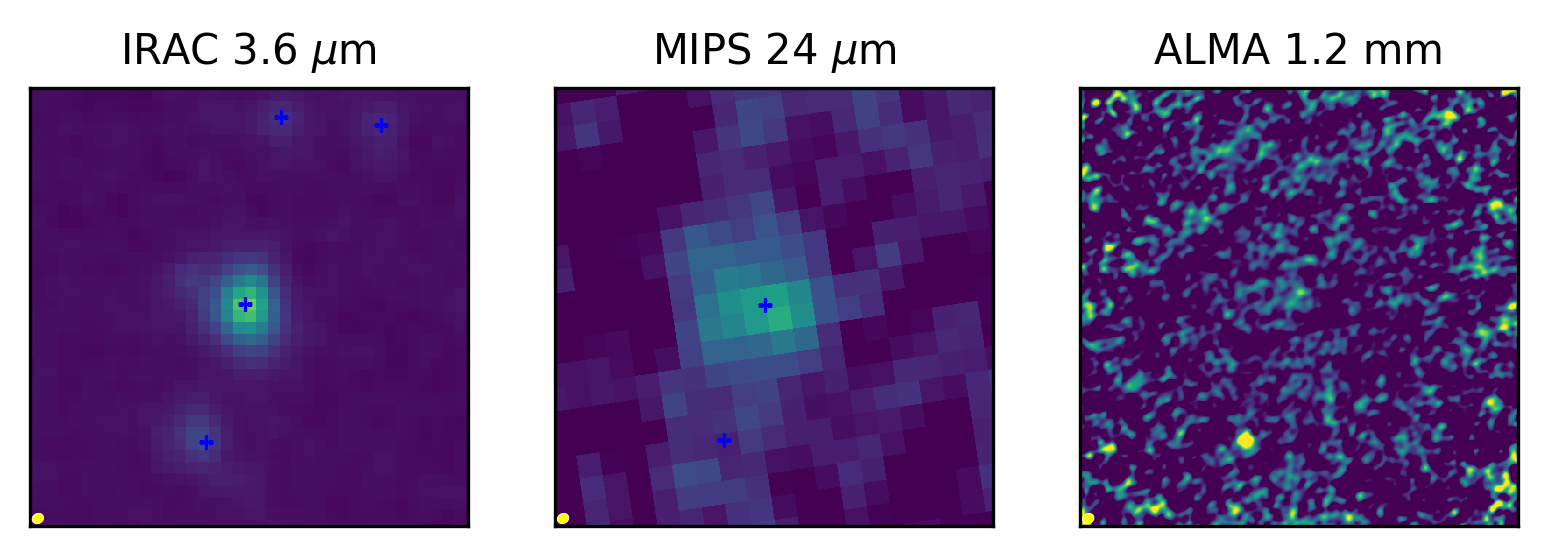

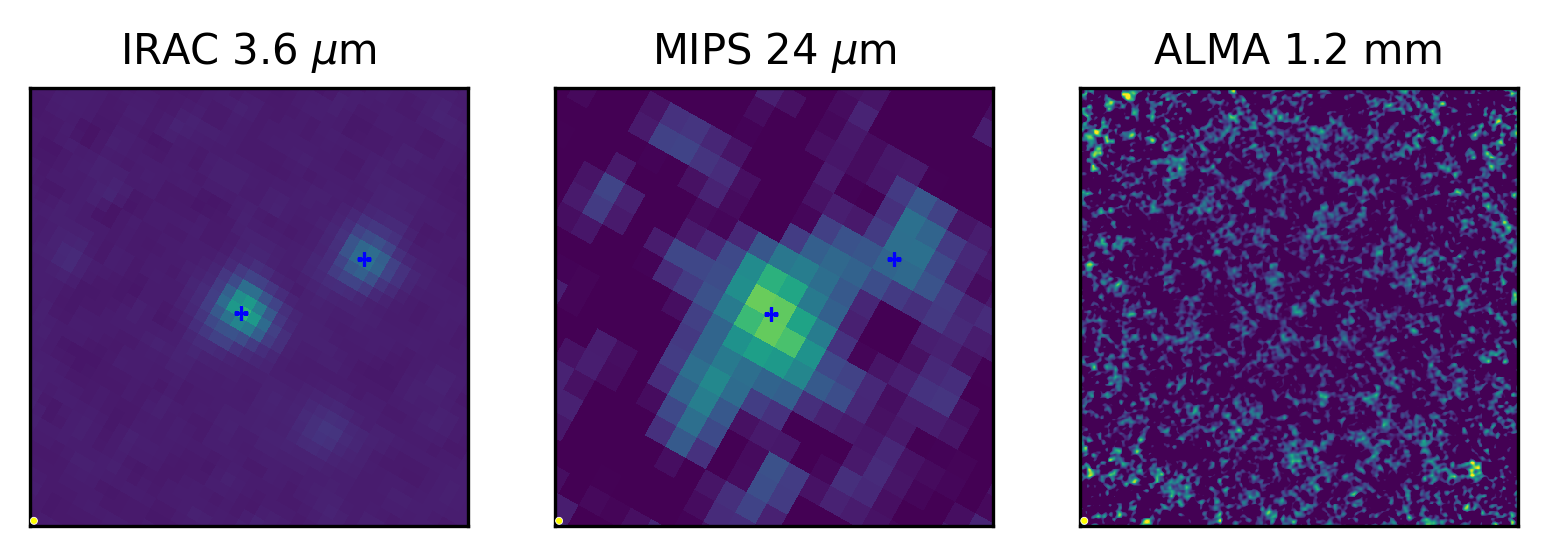

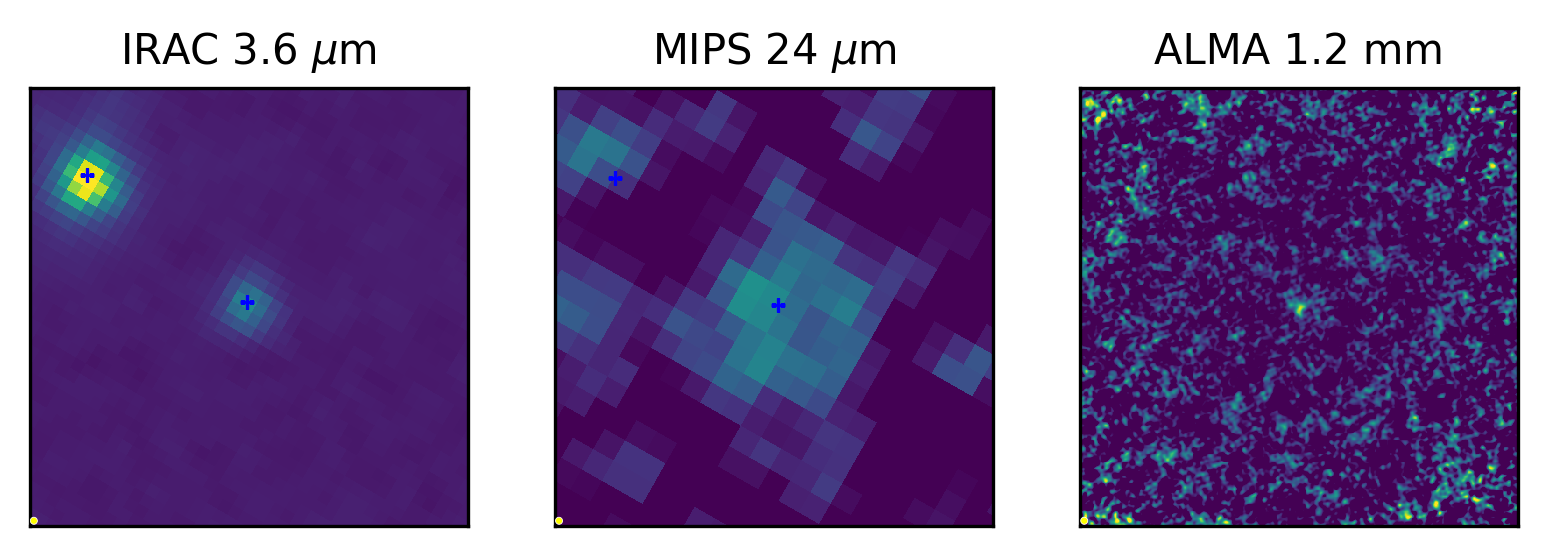

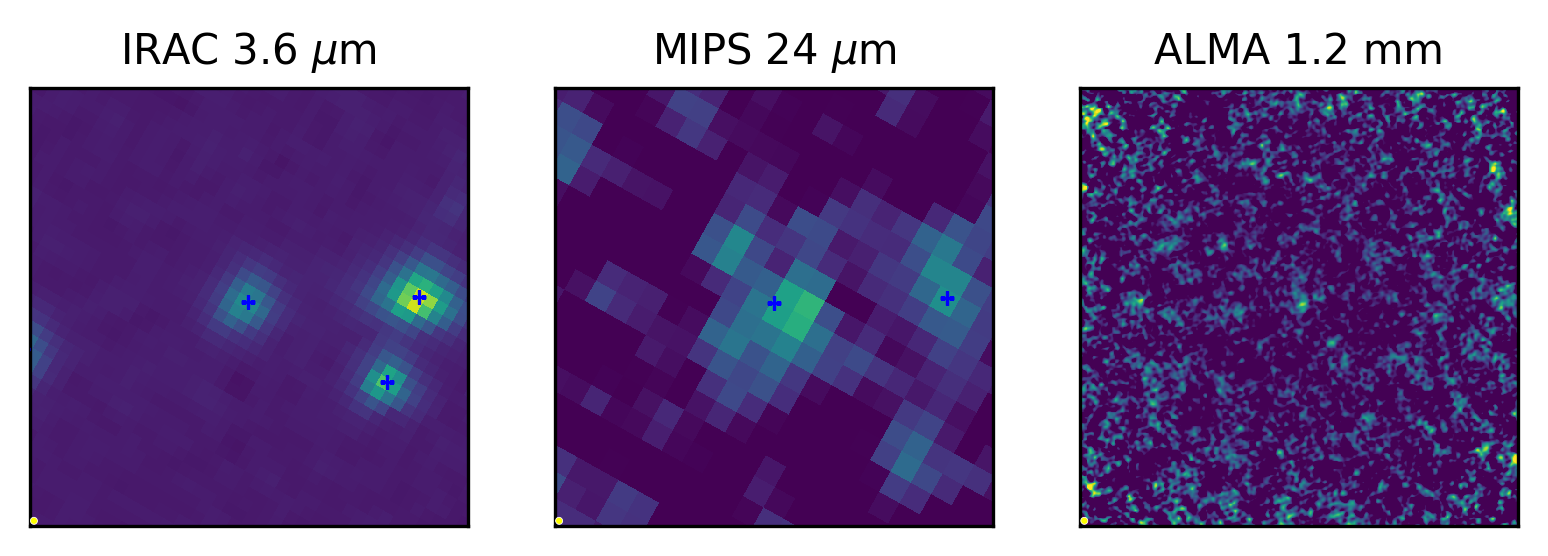

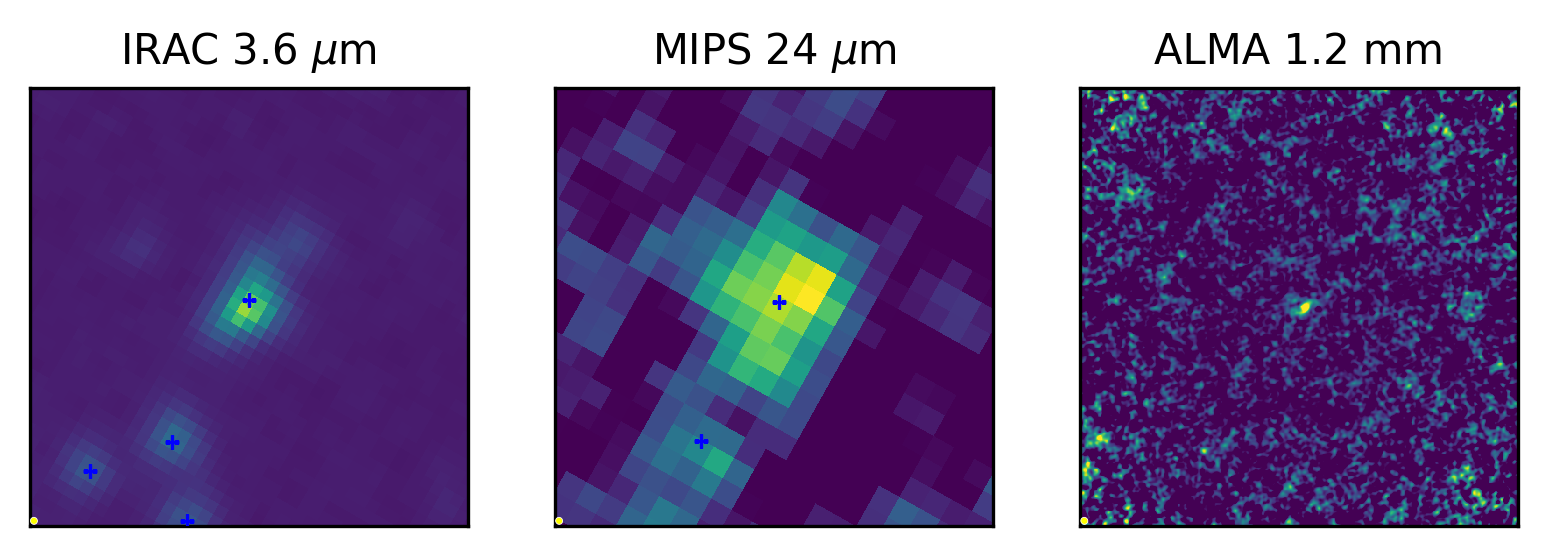

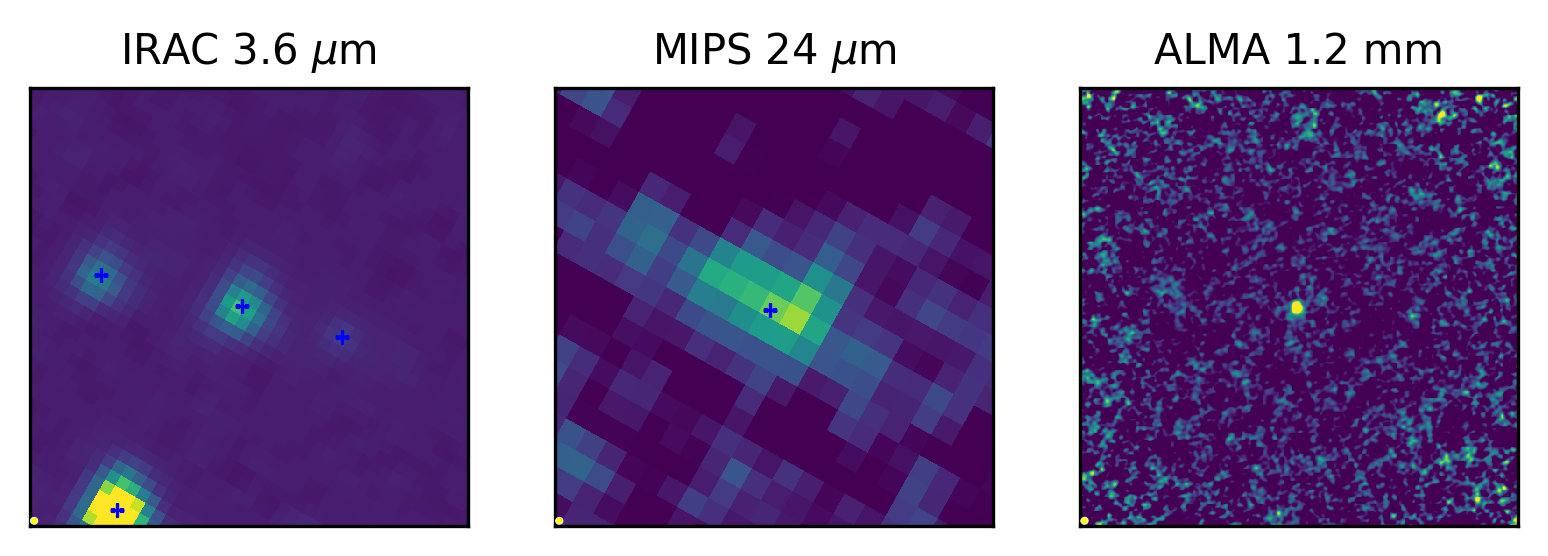

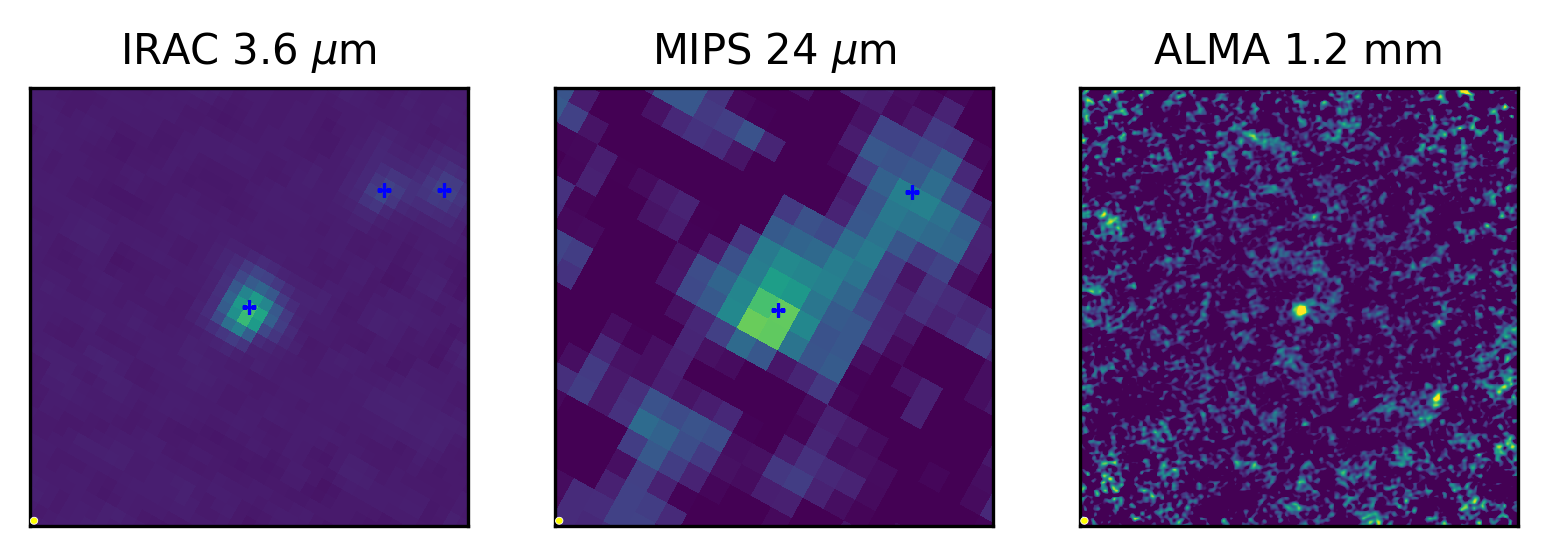

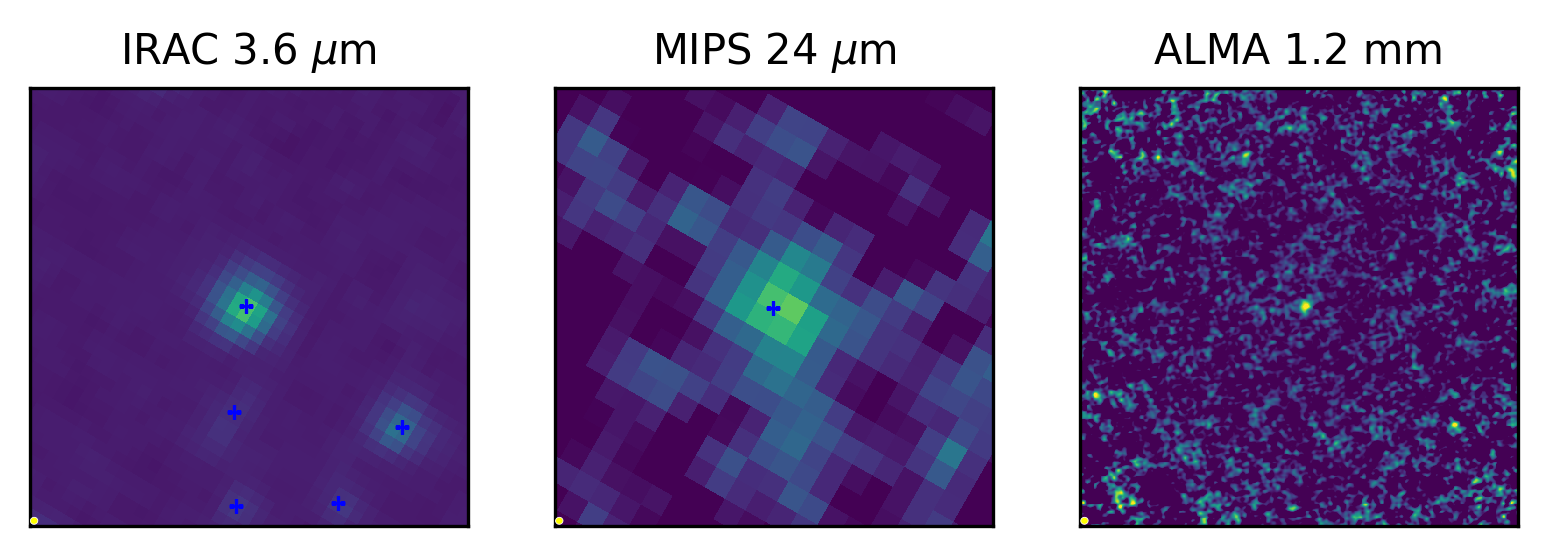

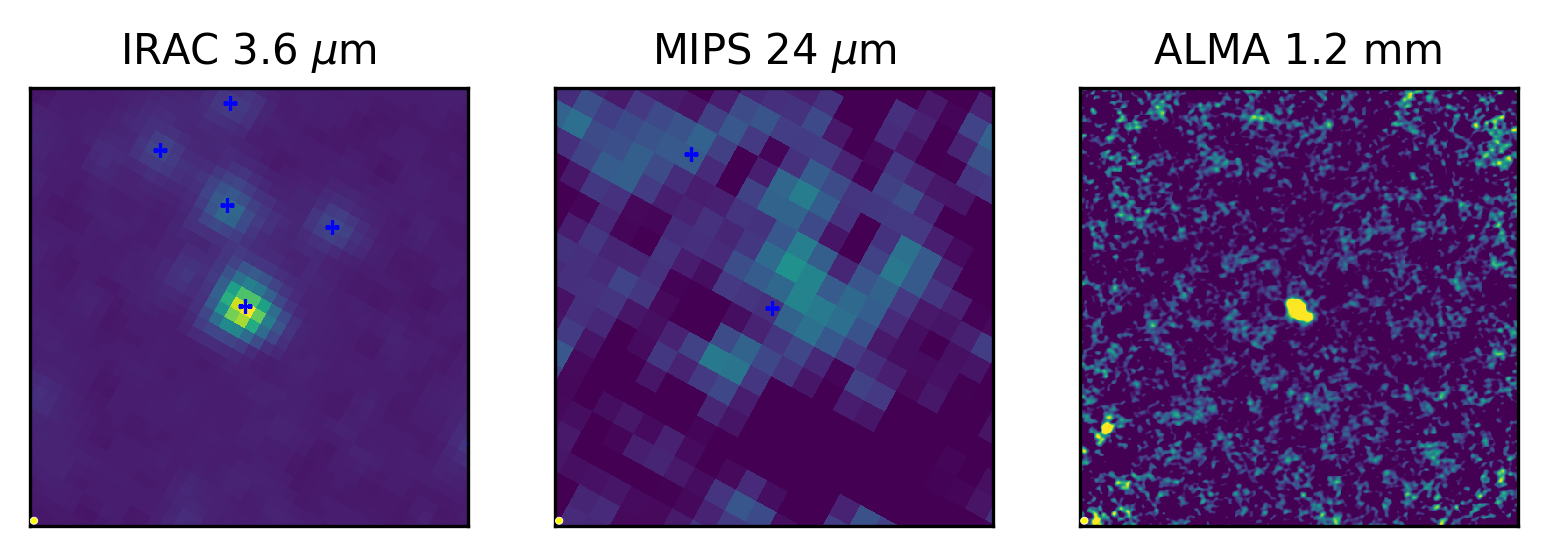

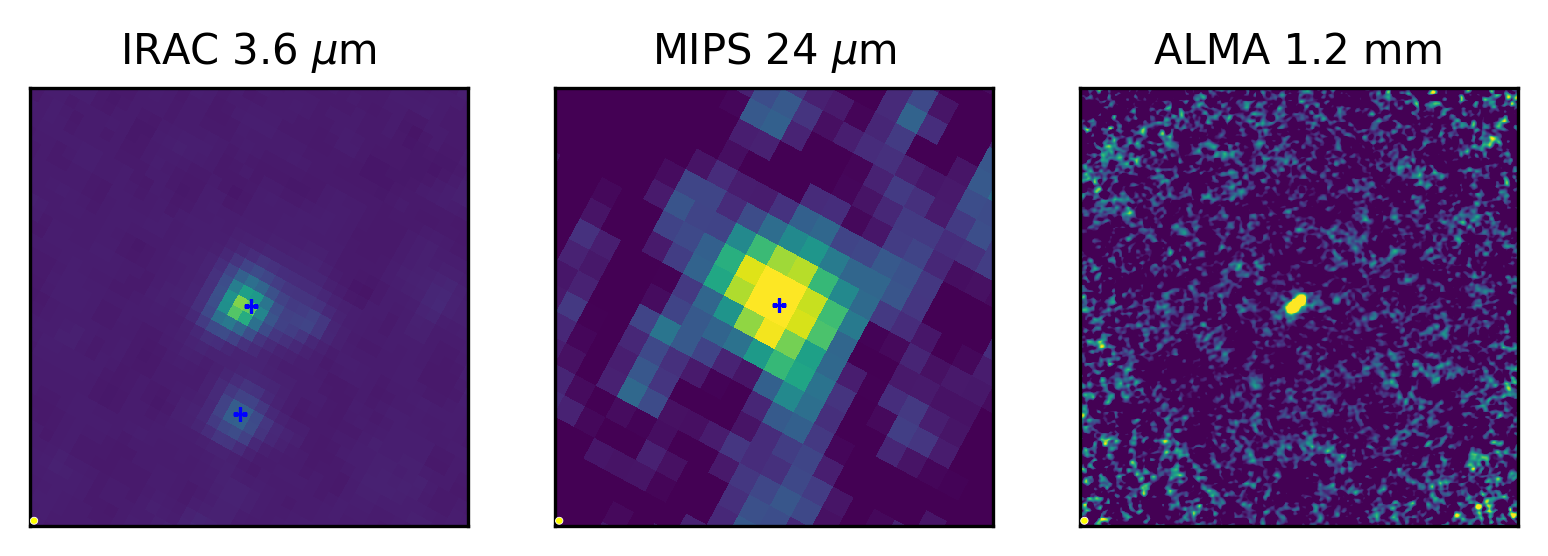

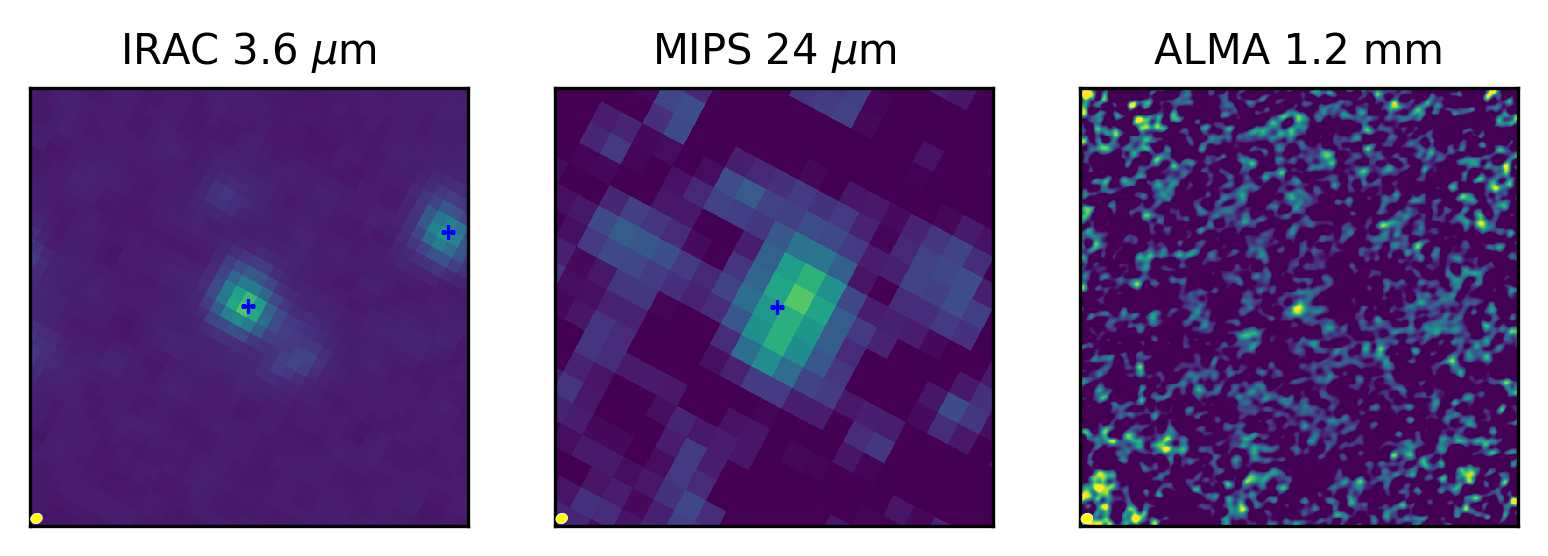

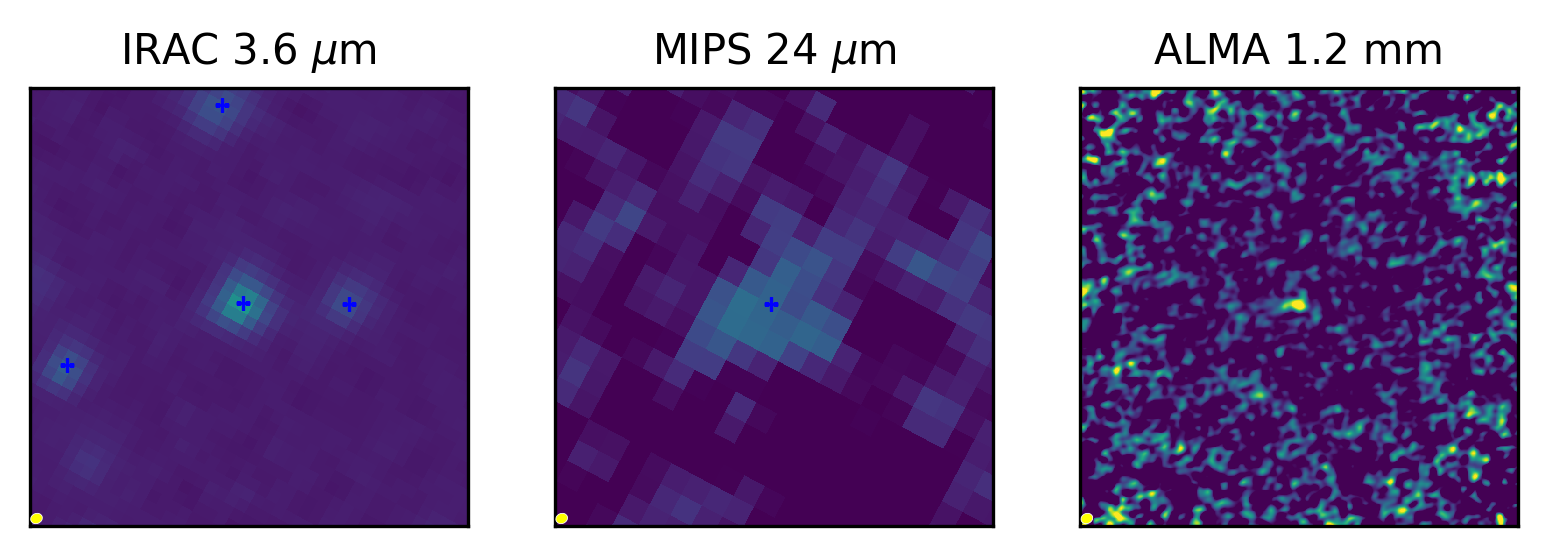

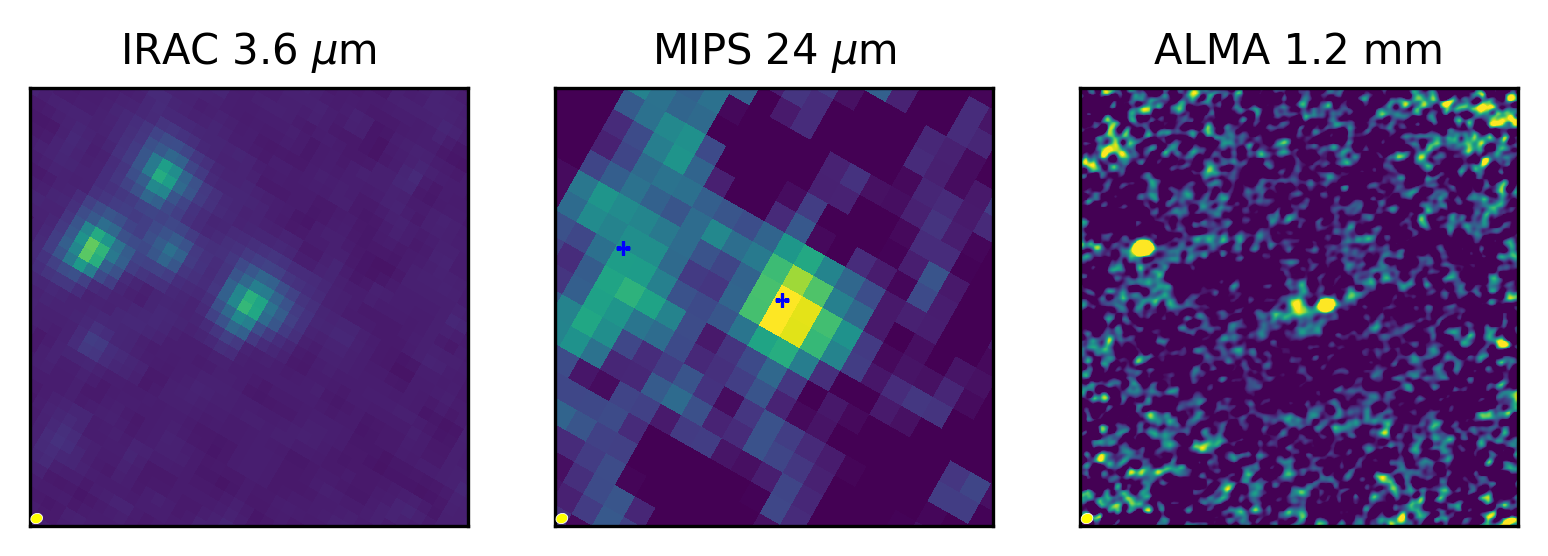

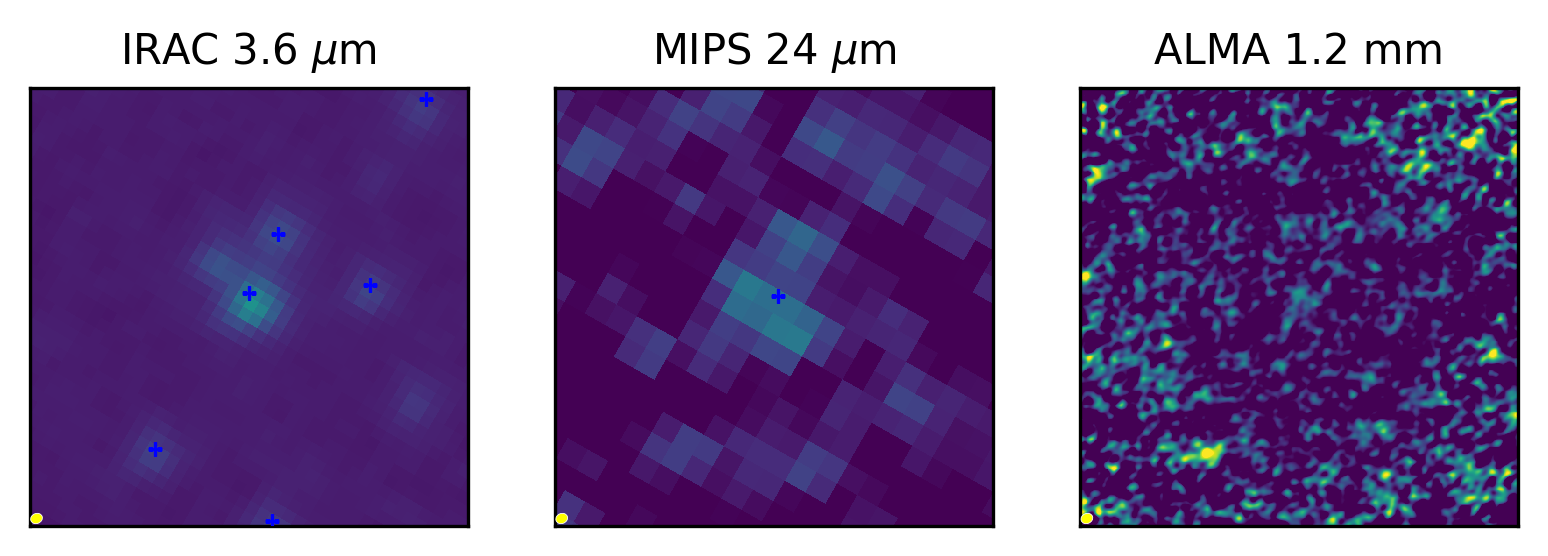

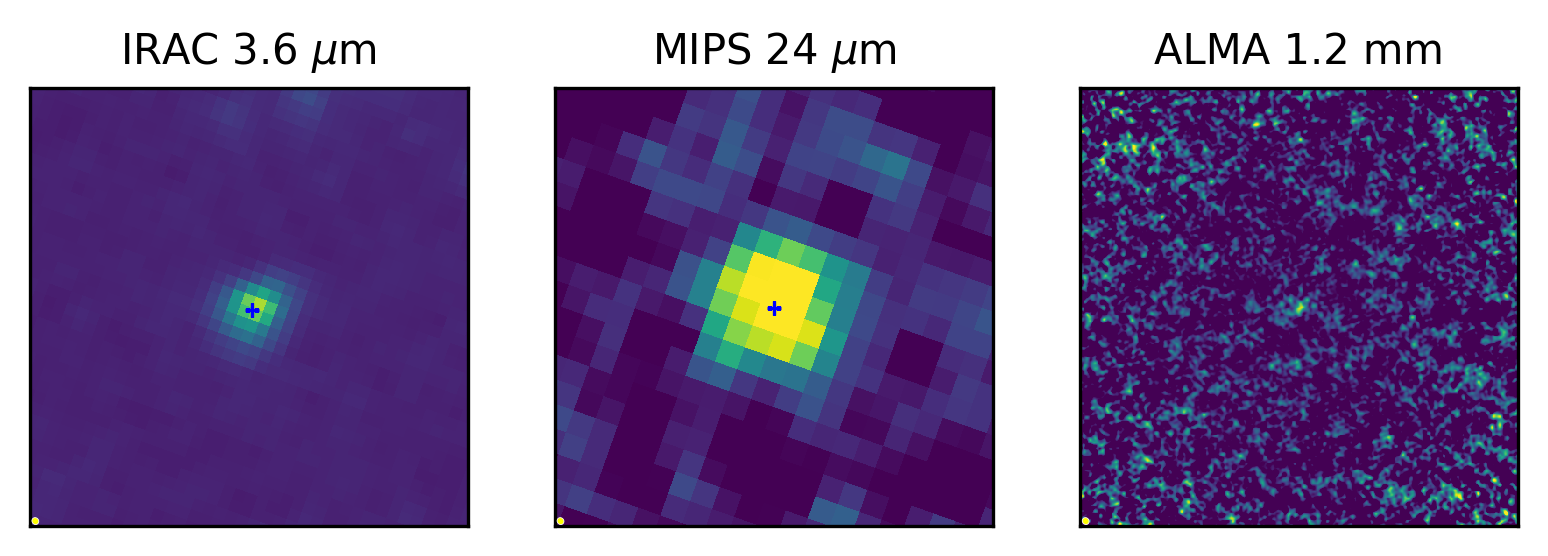

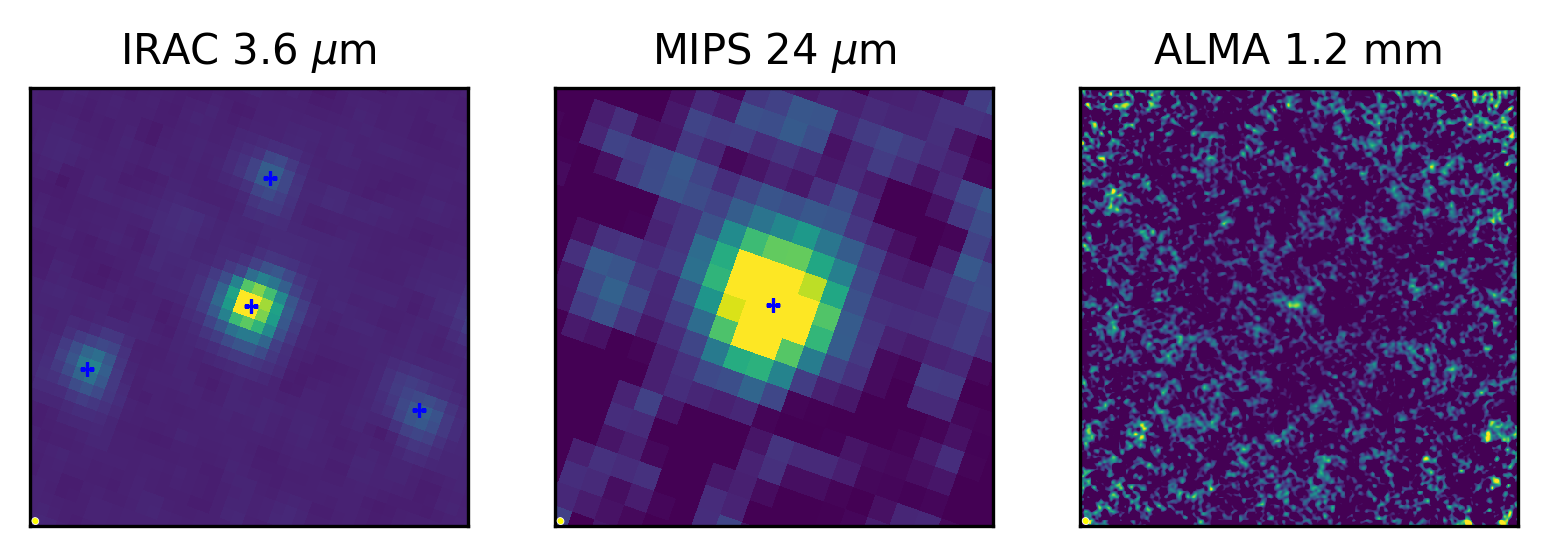

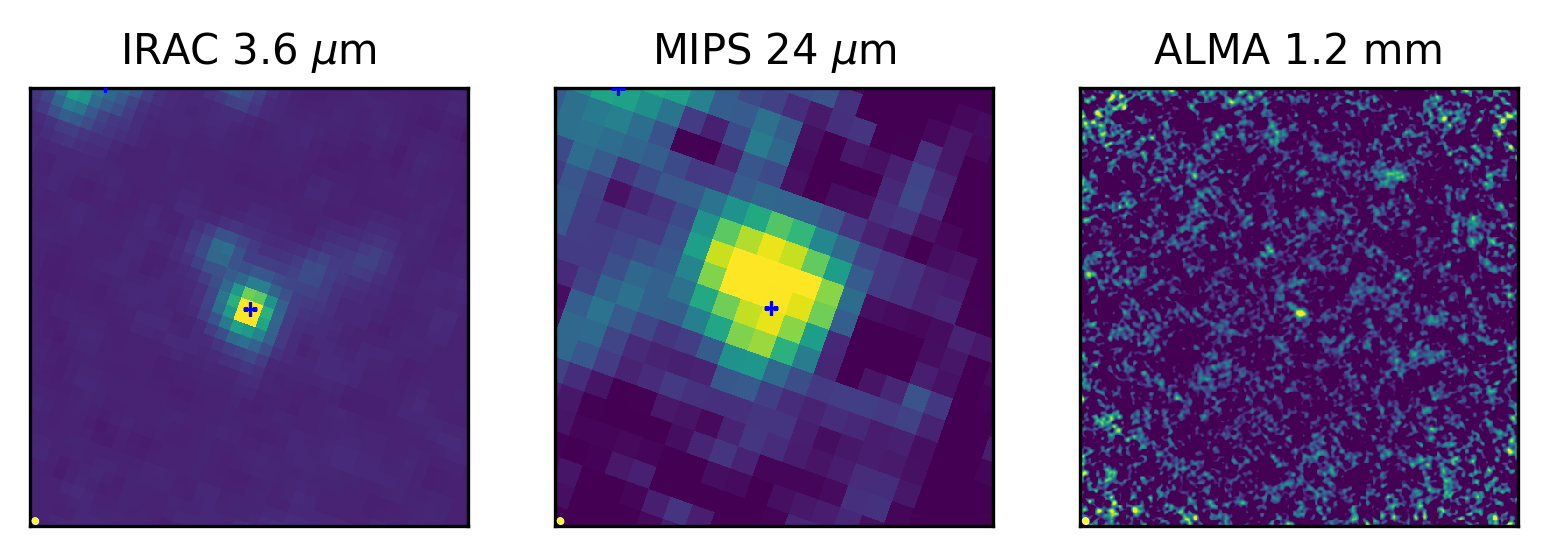

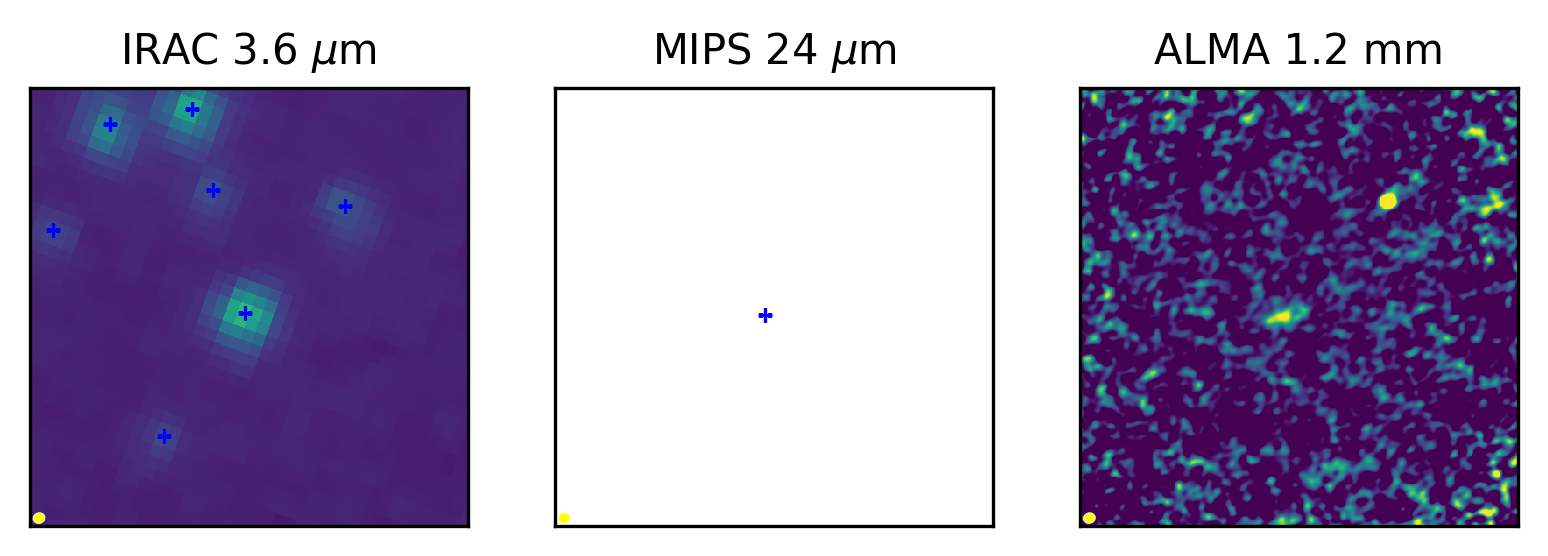

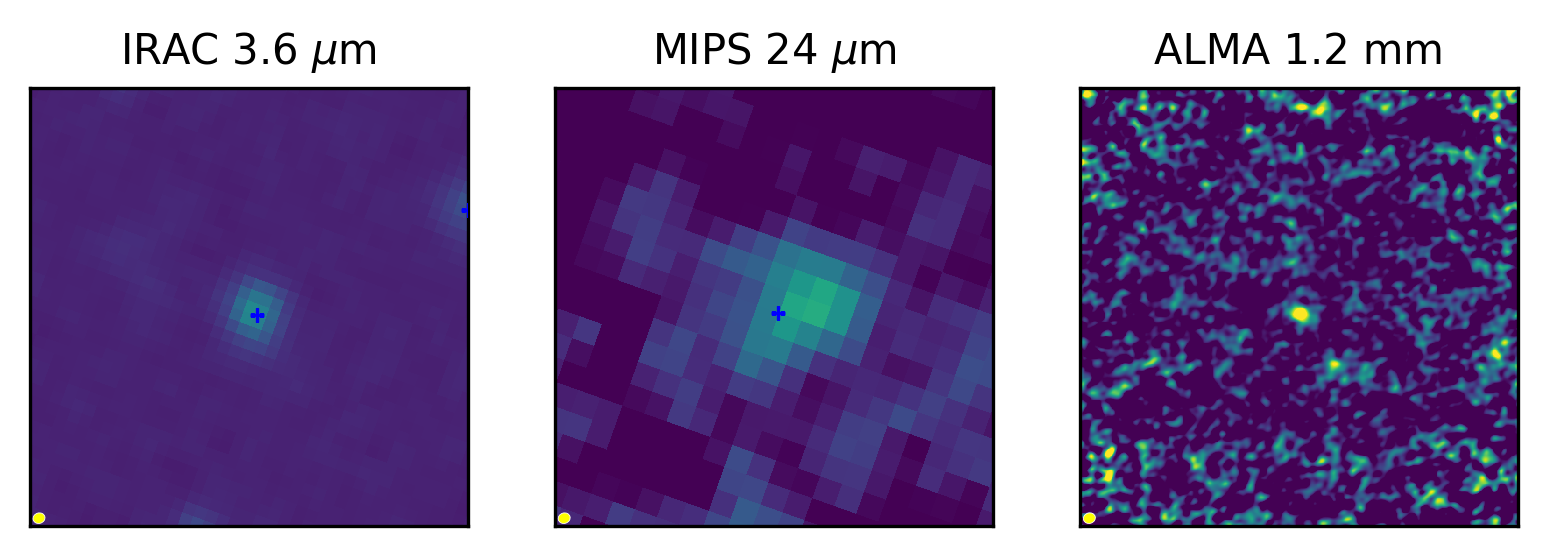

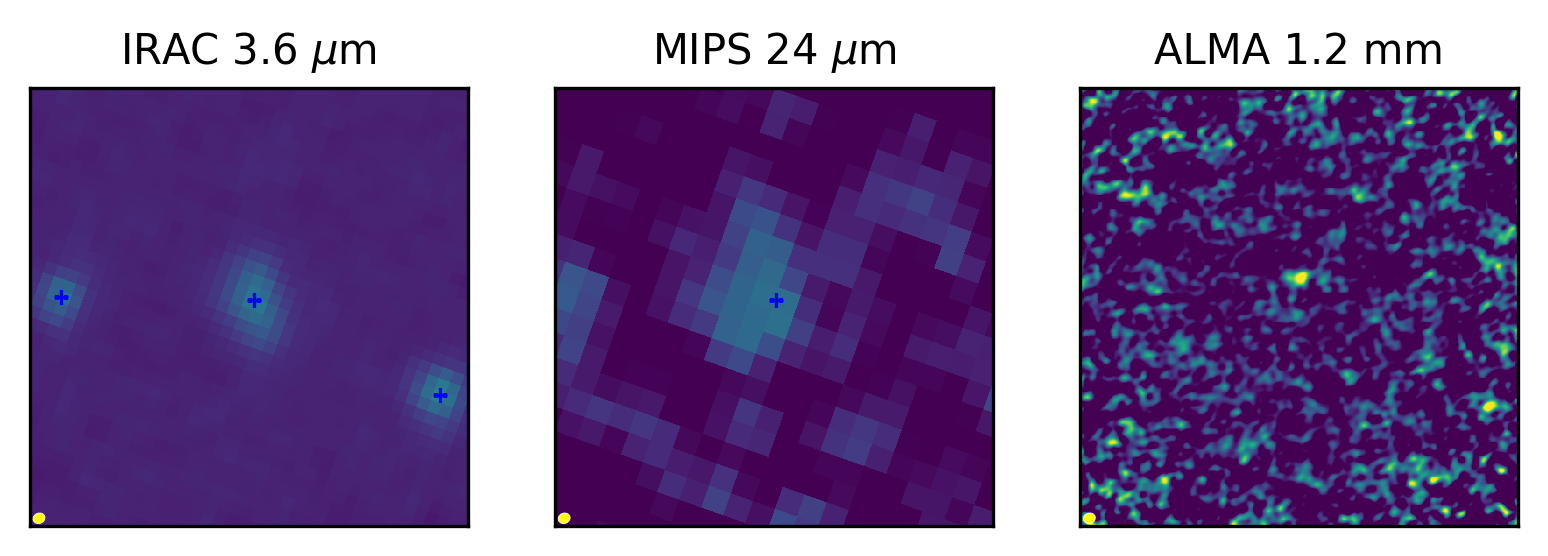

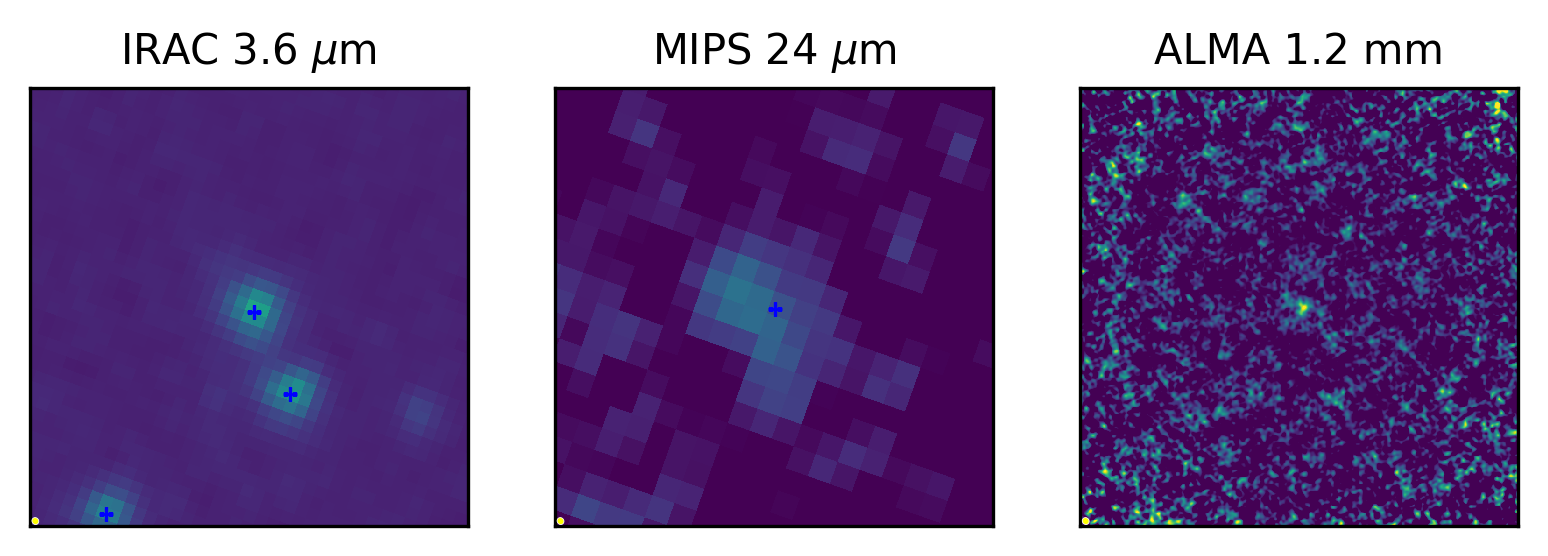

In [11]:
for bcg in bcgs:
    plot_postage_stamps(bcg)

In [12]:
bcgs

['CDFS-18',
 'CDFS19',
 'ES1_z_0.88',
 'ES1_z_0.99',
 'ES1_z_0.99b',
 'ES1_z_1.04',
 'ES1_z_1.38',
 'ES1_z_1.40',
 'ES1_z_1.60',
 'ES1_z_1.65',
 'ES1_z_1.70',
 'ES1-18',
 'ES1-25',
 'ES1-34',
 'ES1-35',
 'XMM_z_0.9',
 'XMM_z_0.81',
 'XMM_z_1.0',
 'XMM-11',
 'XMM-29',
 'XMM-30',
 'XMM-113']

In [13]:
len(bcgs)

22